In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.basemap import Basemap, cm
import gsw as sw
import scipy.stats as ss
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

from netCDF4 import Dataset

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

In [2]:
# import cruise data

in_file = '../data/KuroAlldata.csv'
data = pd.read_csv(in_file, sep = ',').dropna(axis=0, subset=['depth (m)'])

data['theta'] = sw.conversions.pt_from_t(data['S'], data['T(C)'], data['depth (m)'])

data['transect'] = 0
data.loc[(data['station']<9),'transect'] = 'A'
data.loc[((data['station']>8) & (data['station']<17)),'transect'] = 'B'
data.loc[((data['station']>16) & (data['station']<26)),'transect'] = 'C'
data.loc[((data['station']>25) & (data['station']<34)),'transect'] = 'D'
data.loc[(data['station']>33),'transect'] = 'E'

data = data[data['station']!= 41]

data['station'] = data['transect'] + data['station'].astype(str) 
data['sample'] = data['station'] + '-' + data['depth (m)'].astype(int).astype(str)

data.set_index('sample', inplace = True)

in_file = '../data/Kuroshio_Phytoplankton.csv'
phyto = pd.read_csv(in_file, sep = ',')
phyto = phyto[phyto['STATION']!='E41']

in_file = '../data/Kuro_Phytoplankton_coords.csv'
pcoords = pd.read_csv(in_file, sep = ',')
pcoords = pcoords[pcoords['STATION']!='E41']

# join T/S data to sub
pcoords = pd.merge(left = pcoords, right = data[['station','depth (m)','S','theta']], how='left', left_on=['STATION','depth'], right_on=['station','depth (m)'])

phyto = pd.merge(left = phyto, right = pcoords[['STATION','BOTTLE','depth']], how='right', left_on=['STATION','BOTTLE'], right_on=['STATION','BOTTLE'])
phyto['sample'] = phyto["STATION"] + '-' + phyto["depth"].astype(int).astype(str)
phyto.set_index('sample', inplace = True)

data = data.loc[phyto.index, :]

/Users/sclayton/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:809: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/sclayton/anaconda/lib/python2.7/site-packages/gsw-3.0.3-py2.7.egg/gsw/utilities/utilities.py:251: RuntimeWarning: invalid value encountered in less
  SA[SA < 0] = np.ma.masked
/Users/sclayton/anaconda/lib/python2.7/site-packages/gsw-3.0.3-py2.7.egg/gsw/gibbs/library.py:899: RuntimeWarning: invalid value encountered in greater
  nonzero_SA = np.any(SA > 0)
/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/sclayton/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:1367: FutureW

In [3]:
## need to integrate envorinmental data here
from skbio.diversity.beta import pw_distances

ids = phyto.columns[2:-4]
counts = phyto.iloc[0:, 2:-5]
stations = phyto.index

# or exclude everything but dinos and diatoms
ids = phyto.columns[4:-9]
counts = phyto.iloc[0:, 4:-9]
stations = phyto.index

bc_dm = pw_distances(counts, stations, metric = "jaccard")


In [4]:
# fig0 = plt.figure(1, figsize=(16,14), dpi = 600)
# plt.pcolor(bc_dm.data, cmap = 'RdBu_r')
# plt.colorbar()
# plt.axis([0, len(bc_dm.data),0, len(bc_dm.data)])
# plt.show()

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


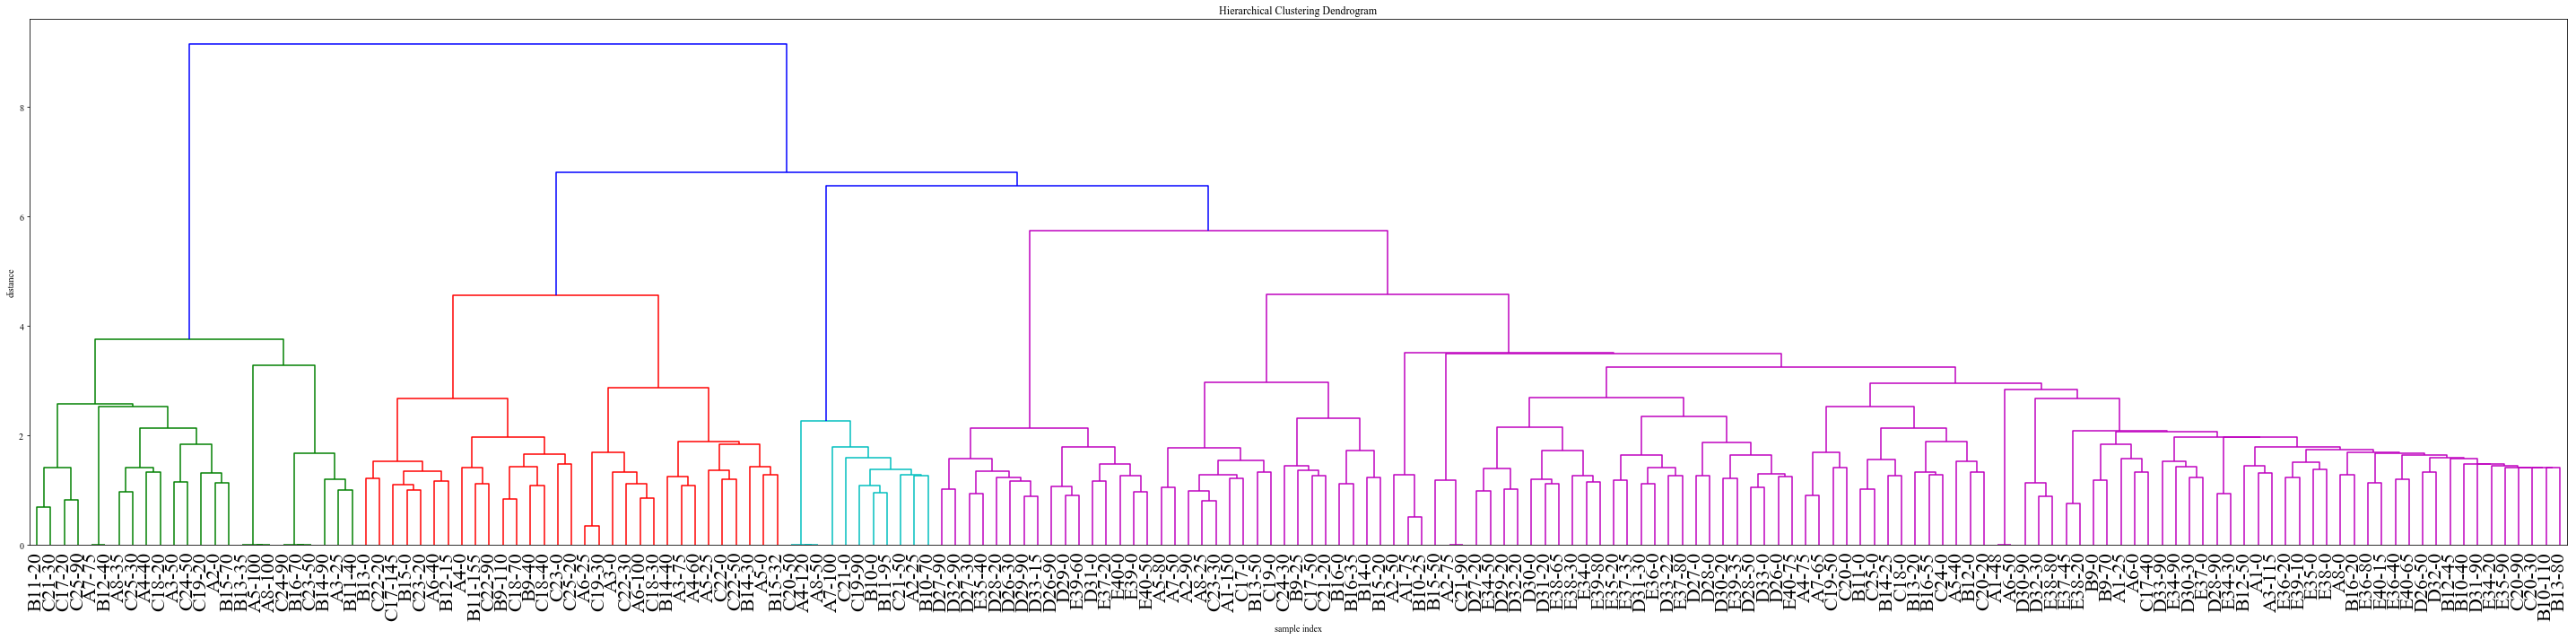

In [5]:
Z = linkage(bc_dm.data, 'ward6')

fig1 = plt.figure(figsize=(40, 10), dpi = 300)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=22.,  # font size for the x axis labels
    labels=bc_dm.ids
)
plt.show()

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     185
number of groups                  4
test statistic              8.46466
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


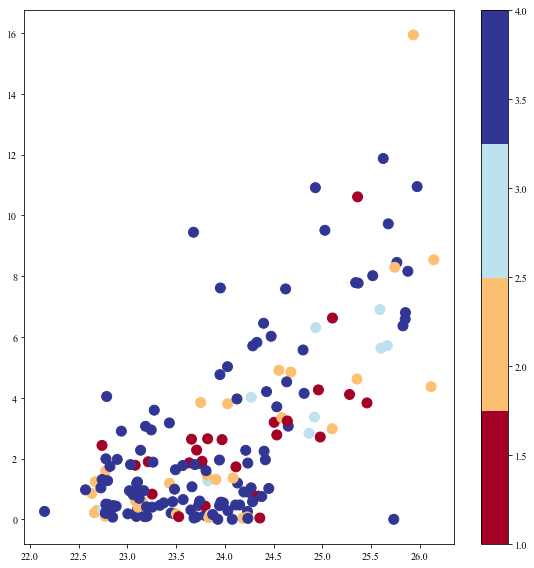

In [16]:
from scipy.cluster.hierarchy import fcluster
max_d = 6.

clusters = fcluster(Z, max_d, criterion='distance')
temp = pcoords[0:185]
temp['cluster'] = clusters

fig2 = plt.figure(figsize = (8,8))

palette = plt.get_cmap('RdYlBu', np.max(clusters))
plt.scatter(data['sigma_t'].values, data['NO3 (uM)'].values, s = 100,c=temp['cluster'].values, cmap = palette)
plt.colorbar()

from skbio.stats.distance import permanova

print permanova(bc_dm, clusters, column=None, permutations=999)

In [12]:
from skbio.stats.ordination import RDA

# X = data[['depth (m)','S', 'sigma_t', 'theta', 'SiO2 (uM)', 'NO3 (uM)','NH4(uM)','PO4 (uM)']].dropna()
X = data[['depth (m)','S', 'theta', 'NO3 (uM)' ]].dropna()#, 'SiO2 (uM)', 'NO3 (uM)']].dropna()

phyto = phyto.loc[X.index, :]
Y = phyto.iloc[:, 2:-5]

e_vars = X.columns

thing = RDA(Y, X, stations, e_vars, scale_Y=True).scores(1)

print thing
print np.max((thing.proportion_explained)*100)


Ordination results:
	Eigvals: 79
	Proportion explained: 79
	Species: 78x79
	Site: 183x79
	Biplot: 4x4
	Site constraints: 183x79
	Species IDs: 'depth (m)', 'S', 'theta', 'NO3 (uM)'
	Site IDs: 'A1-0', 'A1-25', 'A1-48', 'A1-75', 'A1-150', 'A2-0', 'A2-25', 'A2-50', 'A2-75', ...
2.72348326494


In [ ]:
# for n in range(1,np.max(clusters+1)):
#     print 'mean values for cluster ', n
#     print temp[temp['cluster']==n].describe()
#     print '--------'

In [ ]:
pd.unique(clusters)

In [ ]:
phyto['cluster'] = clusters

for n in range(1,np.max(clusters+1)):
    print 'dominant phyto in cluster ', n
    
    tmp = counts[phyto['cluster']==n].sum()
    print tmp.sort_values(axis=0, ascending=False)[0:10]/np.sum(tmp)*100
    print '--------'

In [ ]:

for n in range(1,np.max(clusters+1)):
    print 'transect', n
    
    tmp = counts[phyto['cluster']==n]
    tmp['richness'] = tmp.astype(bool).sum(axis=1)
    
    print tmp['richness'].mean(), '+/-', tmp['richness'].std()
                   
